# Homework Week 2

Second week of December.  Left this too late and did not finish the homework until after the lecture.  But this is important because it gets to results and confidence intervals.  I might have to do this in R to really sort out.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import pymc3 as pm
import arviz as az

## Get data


In [27]:
d = pd.read_csv("../resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Filter out children

As before, we should take out children

In [246]:
d_adult = d[d["age"] >= 18]

## Create QUAP regression model

In [247]:
weight_avg = d_adult["weight"].mean()

In [46]:
with pm.Model() as mod1:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", 178, 20)
    beta = pm.Lognormal("beta", 0 , 1)
    mu = alpha + beta * (d_adult["weight"] - weight_avg)
    height = pm.Normal("height", mu, sigma, observed = d_adult["height"])

In [47]:
map_estimate = pm.find_MAP(model=mod1)
map_estimate

{'sigma_interval__': array(-2.18135226),
 'alpha': array(154.60136748),
 'beta_log__': array(-0.10172172),
 'sigma': array(5.07188029),
 'beta': array(0.90328088)}

## PyMC3 approach

PyMC3 guys really don't like quadratic approximation, so they run a MCMC sample:

In [145]:
with mod1:
    trace = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 15 seconds.


In [146]:
trace

<MultiTrace: 2 chains, 4000 iterations, 5 variables>

In [147]:
tracedf = pm.trace_to_dataframe(trace)
tracedf

,alpha,sigma,beta
0,154.512237,5.153061,0.974840
1,154.651365,5.238934,0.911059
2,154.756683,4.757798,0.871785
3,154.098588,5.262795,0.915660
4,154.334102,5.138811,0.934593
...,...,...,...
7995,154.488388,5.159186,0.921933
7996,153.944851,5.447493,0.863300
7997,154.260510,5.180288,0.869941
7998,155.101742,5.109354,0.912619


In [148]:
with mod1:
    mod1sum = az.summary(trace, round_to=2, kind="stats")
mod1sum

,mean,sd,hdi_3%,hdi_97%
alpha,154.60,0.28,154.07,155.11
sigma,5.11,0.20,4.74,5.48
beta,0.90,0.04,0.82,0.98


In [149]:
new = pd.DataFrame({"weight": [45, 40, 65, 31]})

In [150]:
new.head()

,weight
0,45
1,40
2,65
3,31


The parameters in the summary table are indexes.  Have to use `loc`.

In [260]:
new["exp_height"] = mod1sum.loc["alpha"]["mean"] + mod1sum.loc["beta"]["mean"] * (new["weight"] - weight_avg)
new

,weight,exp_height
0,45,154.608563
1,40,150.108563
2,65,172.608563
3,31,142.008563


## Conclusions during session

Confidence interval is a bit harder.  I think I need to use the samples to generate all this.

Richard uses extract.samples in R.  He will post solutions to some place (Git hub page).
* why does this give 10,000 values in R?
* mu is expected mean; use sigma to get random error
* can use Richard's approach to simulate Fortis job cost and compare!

### Simulate final height

Final height is the observable value (response variable which is the result of everything else in the linear model).  We can recreate the formula for height by including mu, sigma, and the normal distribution.

In [154]:
mu_45 = trace["alpha"] + trace["beta"] * (45 - weight_avg)

In [155]:
mu_45.shape

(8000,)

In [261]:
height_45 = stats.norm.rvs(mu_45, trace["sigma"])

In [270]:
np.quantile(h_45, 0.055)

146.49418214721535

Why can't I get the 5.5% interval to be 146.5?

In [267]:
len(h_45)

8000

In [268]:
sum(h_45 <= 146.5)/len(h_45)

0.055375

In [269]:
sum(h_45 <= 137.88683377797975)/len(h_45)

0.000625

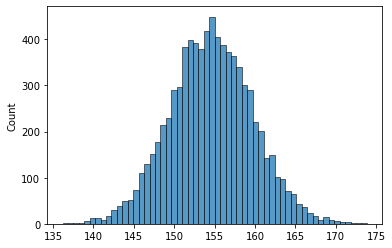

In [263]:
sns.histplot(height_45);

# Redo for data frame

Starting over. Steps:
1. create an empty dataframe of for out-of-sample data
2. estimate the mean using the trace
3. write in the CIs using the trace

Start over by recreating the new dataframe:

## Why this is wrong

It is not necessarily wrong, I don't think.  The problem is the sample size&mdash;it is too small.  We can use the `sample_posterior_predictive` function instead.

No, sample size is not the issue.  Still use `sample_posterior_predictive` because it generates estimates of the response variable (height for every row or predictor variables.  So, if I have an observation with weight = 55, I get 4,000 estimates of height for that weight (varying the parameters of the linear equation on each of the 4000 iterations)

In [175]:
with mod1:
    ppc = pm.sample_posterior_predictive(trace, var_names=["height", "alpha", "beta", "sigma"])

In [178]:
ppc["height"].shape

(8000, 352)

C:\Anaconda3\envs\stat-rethink2-pymc3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


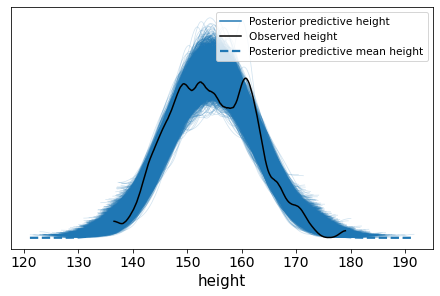

In [185]:
with mod1:
    idata = az.from_pymc3(trace, posterior_predictive=ppc)
az.plot_ppc(idata);

In [210]:
with pm.Model() as mod2:
    sigma = pm.Uniform("sigma", 0, 50)
    alpha = pm.Normal("alpha", 178, 20)
    beta = pm.Lognormal("beta", 0 , 1)
    weight = pm.Data("weight", d_adult["weight"])
    mu = alpha + beta * (weight - weight_avg)
    height = pm.Normal("height", mu, sigma, observed = d_adult["height"])

In [211]:
with mod2:
    trace2 = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 15 seconds.


In [217]:
new_weight = {"weight": new["weight"].values}
new_weight

{'weight': array([45, 40, 65, 31], dtype=int64)}

In [245]:
with mod2:
    pm.set_data(new_weight)
    preds = pm.sample_posterior_predictive(trace2)

In [248]:
preds["height"].shape

(8000, 4)

In [254]:
preds["height"].mean(0)

array([154.46089481, 150.11201569, 172.63817766, 141.94344555])

In [258]:
preds["height"].mean(0)

array([154.46089481, 150.11201569, 172.63817766, 141.94344555])

In [259]:
np.mean(preds["height"], 0)

array([154.46089481, 150.11201569, 172.63817766, 141.94344555])

In [243]:
np.percentile(preds["height"], 0.055, axis=0)

array([137.81217966, 135.58347335, 157.56389708, 130.126736  ])

In [244]:
np.percentile(preds["height"], 0.945, axis=0)

array([143.3388833 , 136.61198706, 160.02739729, 131.60650594])